In [245]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
import glob
import numpy as np
import ast

In [246]:
import os
per_scene = 30

df_labels = pd.read_csv('data/innovaid_hackathon_anima/output_classes.csv')

X = []
y = []
files = glob.glob(f"data/innovaid_hackathon_anima/input_coords_{per_scene}/*.csv")
for file in files:
    df = pd.read_csv(file)
    if df.shape[0] != 50 * per_scene:
        continue
    df.fillna(0, inplace=True)
    df.drop("SCENE_INDEX", inplace=True, axis=1)
    X.append(df.to_numpy().flatten())
    y.append(list(df_labels[df_labels['sid'] == file.split("/")[-1].split('.')[0]]['depression_severity'])[0])


In [247]:
len(X), len(y)

(2963, 2963)

In [248]:
len(X[0])

6000

In [249]:
accuracy_history = []

In [250]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X and y are your feature matrix and labels
# You can use your original data or load it as needed
# X, y = ...

# Convert NumPy arrays to PyTorch tensors
X_tensor = torch.FloatTensor(X).unsqueeze(1)  # Add a channel dimension
y_tensor = torch.LongTensor(y)  # Use LongTensor for integer labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Define a more complex 1D CNN model for 5-class classification
class ComplexCNN(nn.Module):
    def __init__(self, num_classes=5):  # Adjusted for 5 classes
        super(ComplexCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2)
        self.pool = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()

        # Calculate the size of the input to the first linear layer
        self.fc1_input_size = 47872

        self.fc1 = nn.Linear(self.fc1_input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)  # Adjusted for 5 classes
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)  # Softmax for multi-class classification

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.softmax(self.fc3(x))
        return x

# Instantiate the more complex model, cross-entropy loss function, and optimizer
model_complex = ComplexCNN()
criterion_complex = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer_complex = optim.SGD(model_complex.parameters(), lr=0.001)

# Train the more complex model
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    model_complex.train()
    total_loss = 0

    for i in range(0, len(X_train), batch_size):
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer_complex.zero_grad()
        outputs = model_complex(inputs)
        loss = criterion_complex(outputs, labels)
        loss.backward()
        optimizer_complex.step()

        total_loss += loss.item()

    average_loss = total_loss / (len(X_train) / batch_size)

    with torch.no_grad():
        model_complex.eval()
        y_pred_prob_complex = model_complex(X_test)
        _, y_pred_complex = torch.max(y_pred_prob_complex, 1)

    accuracy_complex = accuracy_score(y_test.numpy(), y_pred_complex.numpy())

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Test accuracy: {accuracy_complex:.4f}")

    accuracy_history.append(accuracy_complex)

# Evaluate the more complex model on the test set
with torch.no_grad():
    model_complex.eval()
    y_pred_prob_complex = model_complex(X_test)
    _, y_pred_complex = torch.max(y_pred_prob_complex, 1)

# Calculate accuracy for the more complex model
accuracy_complex = accuracy_score(y_test.numpy(), y_pred_complex.numpy())
print(f"Test Accuracy (More Complex Model): {accuracy_complex}")


Epoch [1/10], Loss: 1.6245, Test accuracy: 0.2597
Epoch [2/10], Loss: 1.6237, Test accuracy: 0.2614
Epoch [3/10], Loss: 1.6226, Test accuracy: 0.2597
Epoch [4/10], Loss: 1.6214, Test accuracy: 0.2580
Epoch [5/10], Loss: 1.6203, Test accuracy: 0.2766
Epoch [6/10], Loss: 1.6192, Test accuracy: 0.2766
Epoch [7/10], Loss: 1.6173, Test accuracy: 0.3137
Epoch [8/10], Loss: 1.6167, Test accuracy: 0.3204
Epoch [9/10], Loss: 1.6155, Test accuracy: 0.3153
Epoch [10/10], Loss: 1.6133, Test accuracy: 0.3170
Test Accuracy (More Complex Model): 0.31703204047217537


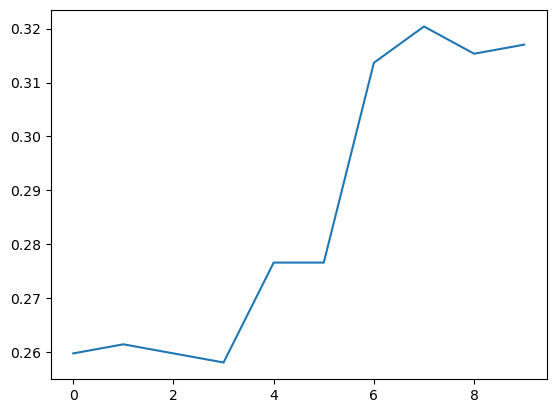

In [251]:
import matplotlib.pyplot as plt

plt.plot(accuracy_history)